In this notebook we consider how to minimize functions via CBO in PyTorch. For neural network related optimizations please refere to the corresponding notebook.

In [1]:
import os
import sys

sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))

Minimizing functions via CBO in PyTorch is possible via the `src.torch.cbo.minimize` function. 

In [2]:
from src.torch.cbo import *

The key requirement for the objective functions is to be compatible with `torch` tensors. Luckily, `torch` provides an exhaustive and flexible API. Please refer to PyTorch documentation for more details.

This implementation provides however a couple of standard optimization function implementations (`src.torch.standard_functions`). As an example, one may consider the following rastrigin function implementation:

```
def rastrigin(v):
    return rastrigin_c()(v)


def rastrigin_c(c=10):
    return lambda v: (v ** 2 - c * torch.cos(2 * torch.pi * v)).sum() + c
```

In the following example we will use the provided implementation of rastrigin function with a constant 2.5:

In [3]:
from src.torch.standard_functions import *

objective = rastrigin_c(2.5)

Now, let's consider the `minimize` function arguments in more details:

The first group of arguments are the general CBO optimization parameters:

* `function` -- objective function to minimize;
* `dimensionality` - dimensionality of the optimization space;
* `n_particles` - number of particles to use;
* `initial_distribution` - distribution to sample the initial particles values, more details below;
* `dt` - CBO dt;
* `l` - CBO lambda;
* `sigma` - CBO sigma;
* `alpha` - CBO alpha;
* `anisotropic` - whether to use anisotropic noise or not.

In order to specify an initial distribution, one may refer to a [torch.distributions](https://pytorch.org/docs/stable/distributions.html). Please only use these distributions.

In [4]:
from torch.distributions import *

The second group of arguments are optimization hyperparameters:
* `batch_size` and `n_particles_batches` - please use **exactly** one of these arguments in order to specify how many batches you want to use;
* `epochs` and `time_horizon` - please use **exactly** one of these arguments in order to specify how many epochs you want to have.

The third group of bool flag arguments is responsible for CBO optimization modifications (by defaul, all the optimizations are disabled):
* `use_partial_update` - whether to use partial or full update;
* `use_additional_random_shift` - whether to apply additional random shift (drift) or not;
* `use_additional_gradients_shift` - whether to use additional gradients shift;
* `random_shift_epsilon` - argument indicating how small the consensus update has to be to apply the additional random shift (drift) to particles;
* `gradients_shift_gamma` - coefficient of a gradient drift.

The fourth group consists of different optional arguments:
* `use_gpu_if_available` - whether to use cude if it is available (by default, disabled);
* `use_multiprocessing` - whether to use multiprocessing (by default, disabled);
* `return_trajectory` - whether return the optimization trajectory along with optimizer or not (by default, disabled);
* `best_particle_alpha` - alpha used to compute the best particle.

The function will return the minimizer (the result of optimization), and (optionally) trajectory of otpimization.

Let's consider a simple example:

In [5]:
minimizer, trajectory = minimize(
    function=objective, dimensionality=1, n_particles=100, 
    initial_distribution=Normal(2, 2),  # torch.distributions.Normal 
    n_particles_batches=1, dt=0.02, l=1, sigma=0.2, alpha=1000, anisotropic=True, 
    epochs=100,
    return_trajectory=True)

In [6]:
minimizer

tensor([-0.0012])

As on may see, the optimization found an optimizer very close to the rastrigin global minmizer 0.

The trajectory is a list of dictionaries, corresponding to the optimization states in chronological order. Each dict stores three values: 
* `V` - particles positions;
* `V_alpha` - the corresponding (current) consensuns;
* `V_best` - position of the best (current) particle.

Let's see:

In [7]:
trajectory[0].keys()

dict_keys(['V', 'V_alpha', 'V_best'])

One can either manually analise the results, or use the standard visualiztion functions provided in `src.torch.visualizations`:

In [8]:
from src.torch.visualizations import *

To compare the convergence with the theoretical one can use function `visualize_trajectory_convergence`:

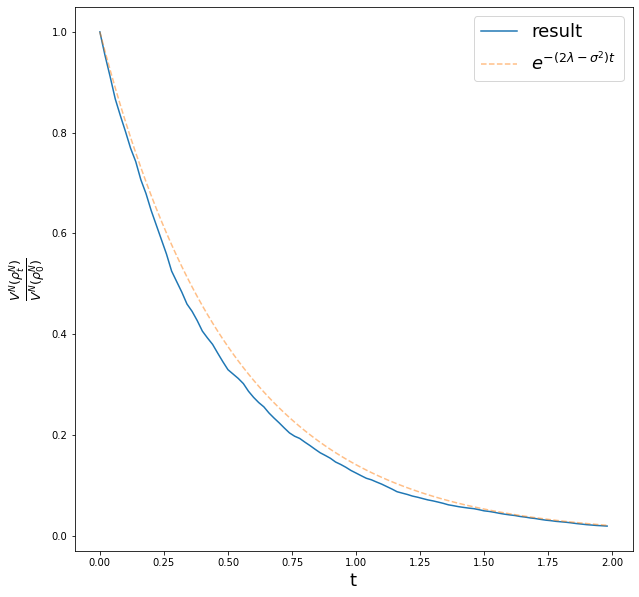

In [10]:
visualize_trajectory_convergence(trajectory, minimizer, display_exponent=True, sigma=0.2, dt=0.02)

To generate a gif correspondin to 1d optimization one can use `visualize_trajectory_1d`. By default, it will generate a gif with a name `trajectory.gif` in the same directory as notebook. It can be changed by specifiying the alternative path via `output_path` argument.

In [11]:
visualize_trajectory_1d(trajectory, objective, 0.01, x_range=(-5, 5))

/home/itukh/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,


<Figure size 1080x1080 with 0 Axes>

One can display the generated gif in the following way:

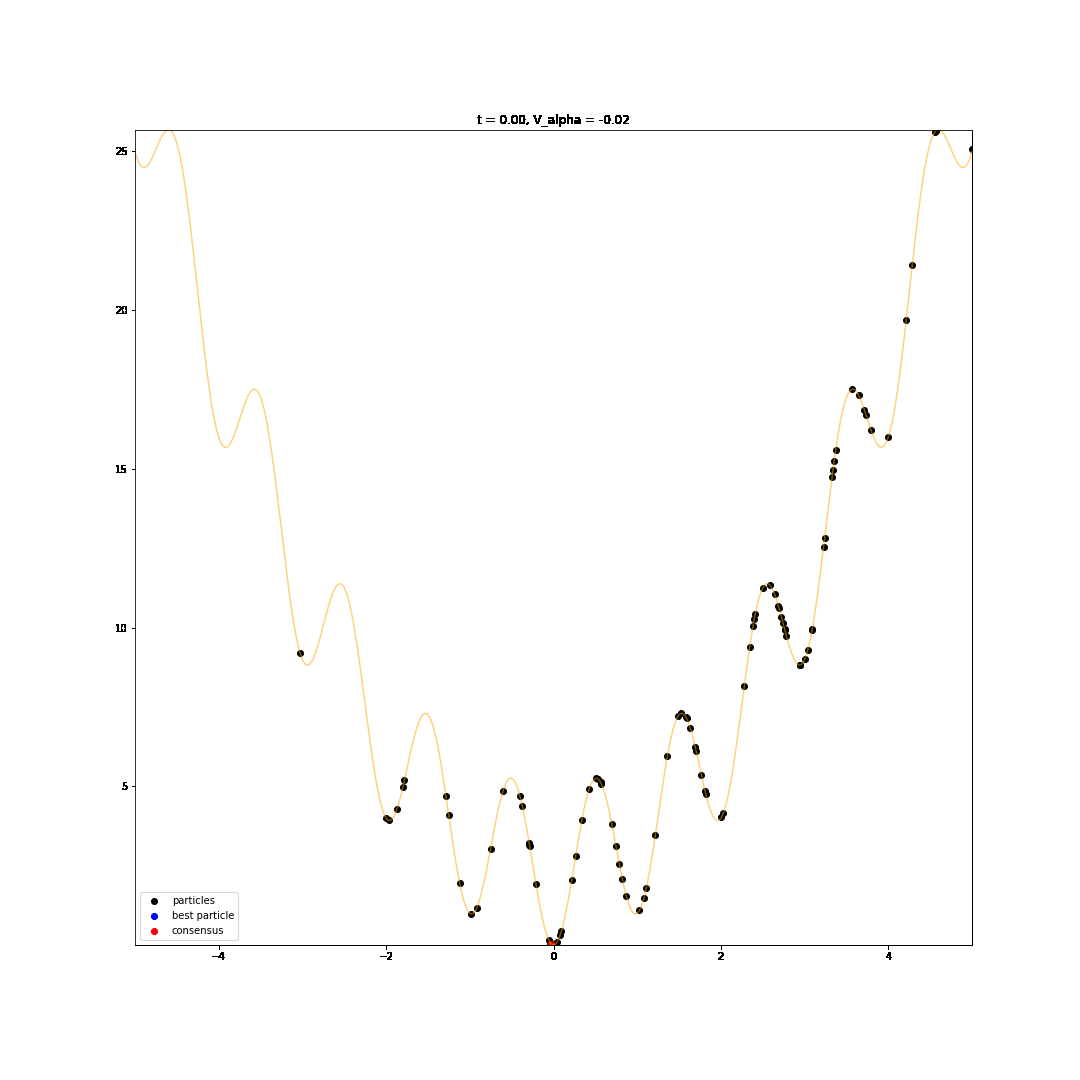

In [12]:
from IPython.display import Image
Image(filename='trajectory.gif')

Let's consider an example, in which we use gradients (which force particles to move to local mininimizers):

In [ ]:
minimizer, trajectory = minimize(
    function=objective, dimensionality=1, n_particles=100, initial_distribution=Normal(2, 2), 
    n_particles_batches=1, dt=0.01, l=1, sigma=0.2, alpha=1000, anisotropic=True, 
    use_additional_gradients_shift=True, gradients_shift_gamma=1e-5,
    epochs=100, return_trajectory=True)

In [ ]:
visualize_trajectory_convergence(trajectory, minimizer, display_exponent=True, sigma=0.2)

In [ ]:
visualize_trajectory_1d(trajectory, objective, 0.01, x_range=(-5, 5), output_path='rastrigin_grads.gif')
Image(filename='rastrigin_grads.gif')